## CSE251B PA1

In [4]:
#Basic setups 
import numpy as np
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

### Part 1: Load and preprocess the data

In [5]:
from dataloader import load_data
from PCA import PCA

In [6]:
#Load and preprocess the data
#We change the load_data function by deleting the value assigned to datatype in the definition
aligned_data,cnt = load_data("./aligned/")

Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images


### Part 2: Cross Validation Procedure

In [7]:


from random import shuffle
import math
def kFold(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffled_idx = np.random.shuffle(index)
    shuffled_data_temp = data[shuffled_idx]
    shuffled_data = shuffled_data_temp[0,:,:]
    
    print("original shape:",data.shape)
    print("shuffled shape:",shuffled_data.shape)
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    index_train = int(set_size*(K-2))
    index_test = int(set_size*(K-1))

    
    training_set = shuffled_data[:index_train]
    testing_set = shuffled_data[index_train:index_test]
    val_set = shuffled_data[index_test:]
    print("trainshape:",training_set.shape)
    return training_set,testing_set,val_set



In [8]:
def dataSplit(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffled_idx = np.random.shuffle(index)
    shuffled_data = data[shuffled_idx]
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    folds = []
    for i in range(K-1):
        temp = data[i*set_size:(i+1)*set_size,:]
        folds.append(temp)
    folds.append(data[K*set_size:,:])
    return folds

In [9]:
def img_flatten(img):
    """This function is used to convert 2-D images to 1-D vectors"""
    flatten_img = []
    for i in range(len(img)):
        flatten_img.append(img[i].flatten())
    return np.array(flatten_img)

In [10]:
def plot_top_PCs(eigenvectors,n):
    imgs = []
    plt.figure()
    for i in range(n):
        eigen = egenvectors[i]
        image = np.reshape(eigen,(200,300))
        image = Image.fromarray(image)
        imgs.append(img)
        plt.subplot(1,n,i)
        plt.imshow(imgs[i])

In [11]:
def normalize_img(img):
    """This function is used to normalize given images"""
    mean = np.mean(img,axis = 1)
    std = np.std(img,axis = 1)
    img = img.T-mean
    img = img/(std+0.1)
    img = img.T
    return img

In [12]:
#Train Process
#Load data 
minivan = aligned_data.get('Minivan')
convertible = aligned_data.get('Convertible')
pickup = aligned_data.get('Pickup')
sedan = aligned_data.get('Sedan')

minivan_flatten = img_flatten(minivan)
convertible_flatten = img_flatten(convertible)
pickup_flatten = img_flatten(pickup)
sedan_flatten = img_flatten(sedan)

#Perform K-Fold cross validation
num_fold = 10
trainM,testM,valM = kFold(num_fold,minivan_flatten)
trainC,testC,valC = kFold(num_fold,convertible_flatten)
trainP,testP,valP = kFold(num_fold,pickup_flatten)
trainS,testS,valS = kFold(num_fold,sedan_flatten)

#Perform PCA to find top PCs
num_PC = 4
#Minivan
projectedM, mean_imageM, top_sqrt_eigen_valuesM, top_eigen_vectorsM = PCA(trainM,num_PC)
#Convertible
projectedC, mean_imageC, top_sqrt_eigen_valuesC, top_eigen_vectorsC = PCA(trainC,num_PC)
#Pickup
projectedP, mean_imageP, top_sqrt_eigen_valuesP, top_eigen_vectorsP = PCA(trainP,num_PC)
#Sedan
projectedS, mean_imageS, top_sqrt_eigen_valuesS, top_eigen_vectorsS = PCA(trainS,num_PC)

original shape: (148, 60000)
shuffled shape: (148, 60000)
trainshape: (112, 60000)
original shape: (149, 60000)
shuffled shape: (149, 60000)
trainshape: (112, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)


In [13]:
#foldM = dataSplit(num_fold,minivan_flatten)
#print(foldM[0])
#print(np.array(foldM[0]).shape)

In [14]:
X_train = np.concatenate((projectedM, projectedC), axis=0)
y_train = np.concatenate((np.zeros(projectedM.shape[0]), np.ones(projectedC.shape[0])), axis=0)



In [15]:
class LogisticRegressionClassifier:
        def __init__(self, max_iter=200, learning_rate=0.01):
            self.max_iter = max_iter
            self.learning_rate = learning_rate
        

        def sigmoid(self,x):
            """This function is used to calculate logistic function"""
            return 1/( 1 +np.exp(-x))

        def insert_bias(self,x):
            """This function is used to add bias row w0 to the data"""
            x = np.insert(x,0,1,axis=1)
            return x

        def predict(self,x,weight):
            """This function is used to do clssification"""
            probs = self.sigmoid(np.dot(x,weight))
            
            predictions = np.zeros_like(probs)
            
            #Assign tag 0 to probability less than 0.5 and tag 1 to probability greater than 1
            for i in range(len(probs)):
                if probs[i]>=0.5:
                    predictions[i]=1
                else:
                    predictions[i]=0
              
            return predictions
        
        def accuracy(self,x,y,weight):
            """This function is used to calculate the accuracy of the prediction result"""
            prediction = self.predict(x,weight)
            correct = 0
   
            for i in range(len(prediction)):
                
                if (prediction[i] == 1 and y[i] == 1) or (prediction[i]== 0 and y[i] == 0):
                    correct = correct+1
            return correct / len(x)
        
        def cross_entropy(self,x,y,weight):
            """This function is used to calculate the loss/error"""
            y_hat = self.sigmoid(x*weight.T)
            cost = 0
            cost_temp = np.multiply(-y,np.log(y_hat))-np.multiply((1-y),np.log(1-y_hat))
            cost = np.sum(cost_temp)/x.shape[0]
              
            return cost

        def gradientDescent(self,x_train,y_train,x_hold,y_hold,x_test,y_test):
            """This function is used to perform logistic regression via gradient descent"""
            #Attach bias to the original data
            x_insert = self.insert_bias(x_train)
            print("x_insert shape",x_insert.shape)
            x_hold_insert = self.insert_bias(x_hold)
            x_test_insert = self.insert_bias(x_test)
            
            #Initialize weights
            weight = np.zeros((len(x_insert[1]), 1), dtype=np.float32)
            
            #Initialize error and accuracy recording arrays
            train_error = np.zeros((self.max_iter,1))
            hold_out_error = np.zeros((self.max_iter,1))
            test_error = np.zeros((self.max_iter,1))
            
            train_acc = np.zeros((self.max_iter,1))
            hold_out_acc=np.zeros((self.max_iter,1))
            test_acc = np.zeros((self.max_iter,1))
            
            
            
            for iter_ in range(self.max_iter):
                self.weights = np.zeros((len(x_insert[0]), 1), dtype=np.float32)
                #Calculate cost function and its gradient
                loss = self.cross_entropy(x_insert,y_train,weight)
                
                                
                #Update weight parameters
                for i in range(len(x_train)):
                    y_hat = self.sigmoid(np.dot(x_insert[i], self.weights))
                    error = y_train[i] - y_hat
                    self.weights += self.learning_rate * error * np.transpose([x_insert[i]])
       
                    #Update loss and acc for training set
                    train_error[iter_] = loss
                    train_acc[iter_] = self.accuracy(x_insert,y_train,self.weights)
                                                 
                    #Calculate the error for hold out set using updated weight
                    loss_hold = self.cross_entropy(x_hold_insert,y_hold,self.weights)
                    hold_out_error[iter_] = loss_hold
                    hold_out_acc[iter_] = self.accuracy(x_hold_insert,y_hold,self.weights)
                
                    #Calculate the error for test set using updated weight
                    loss_test= self.cross_entropy(x_test_insert,y_test,self.weights)
                    test_error[iter_] = loss_test
                    test_acc[iter_] = self.accuracy(x_test_insert,y_test,self.weights)
                
            return train_error,train_acc,hold_out_error,hold_out_acc,test_error,test_acc
                    
                

In [16]:
def projectPC(x,mean_image, top_sqrt_eigen_values, top_eigen_vectors):
    """This function is used to project the data x on the given training set x_train"""
    
    msd = x - mean_image
    projected_image = np.matmul(msd,top_eigen_vectors)/top_sqrt_eigen_values

    return projected_image
    

### Part 5(b) Evaluate the model on Convertible vs Minivan using the resized data


In [17]:
#Load data 
resized_data,resize_cnt = load_data("./resized/")

Car types: ['Convertible', 'Minivan'] 

Convertible: 150 # of images
Minivan: 150 # of images


In [18]:
num_PC = 10
minivan_resize = resized_data.get('Minivan')
convertible_resize = resized_data.get('Convertible')

minivan_resize_flatten = img_flatten(minivan_resize)
convertible_resize_flatten = img_flatten(convertible_resize)

num_fold = 10
trainM_resize,testM_resize,valM_resize = kFold(num_fold,minivan_resize_flatten)
trainC_resize,testC_resize,valC_resize = kFold(num_fold,convertible_resize_flatten)

print("trainM_resize shape:",trainM_resize.shape)

original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
trainM_resize shape: (120, 60000)


In [19]:
#Perform PCA to find top PCs on training set
#Minivan
projectedM_resize, mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize = PCA(trainM_resize,num_PC)
#Convertible
projectedC_resize, mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize = PCA(trainC_resize,num_PC)


#Project handout data on top PCs
projectedM_val = projectPC(trainM_resize,mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize)
projectedC_val = projectPC(trainC_resize,mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize)

#Project testing data on top n PCs
projectedM_test = projectPC(trainM_resize,mean_imageM_resize, top_sqrt_eigen_valuesM_resize, top_eigen_vectorsM_resize)
projectedC_test = projectPC(trainC_resize,mean_imageC_resize, top_sqrt_eigen_valuesC_resize, top_eigen_vectorsC_resize)

In [20]:
#Initialize training,val and testing dataset
X_train = np.concatenate((projectedM_resize, projectedC_resize), axis=0)
y_train = np.concatenate((np.zeros(projectedM_resize.shape[0]), np.ones(projectedC_resize.shape[0])), axis=0)
y_train = y_train.reshape(y_train.shape[0],1)

X_hold = np.concatenate((projectedM_val, projectedC_val), axis=0)
y_hold = np.concatenate((np.zeros(projectedM_val.shape[0]), np.ones(projectedC_val.shape[0])), axis=0)
y_hold = y_hold.reshape(y_hold.shape[0],1)

X_test = np.concatenate((projectedM_test, projectedC_test), axis=0)
y_test = np.concatenate((np.zeros(projectedM_test.shape[0]), np.ones(projectedC_test.shape[0])), axis=0)
y_test = y_test.reshape(y_test.shape[0],1)

print("shape of x_train,x_test and x_hold are",X_train.shape,X_test.shape,X_hold.shape)
print("shape of y_train,y_test and y_hold are",y_train.shape,y_test.shape,y_hold.shape)

shape of x_train,x_test and x_hold are (240, 10) (240, 10) (240, 10)
shape of y_train,y_test and y_hold are (240, 1) (240, 1) (240, 1)


In [21]:
#Perform logistic regression via geadient descent 
lr_clf = LogisticRegressionClassifier(max_iter=300,learning_rate=0.1)
train_error,train_acc,hold_out_error,hold_out_acc,test_error,test_acc = \
lr_clf.gradientDescent(X_train,y_train,X_hold,y_hold,X_test,y_test)

x_insert shape (240, 11)


In [22]:
print(test_error,hold_out_error,train_error)

[[8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07876888]
 [8.07

In [23]:
#Find the best weight corresponding to the smallest hold-out error
idx_best_hold_out = np.where(hold_out_error == hold_out_error.min())
accuracy = test_acc[idx_best_hold_out]
print("The test accuracy is :",accuracy)

The test accuracy is : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5

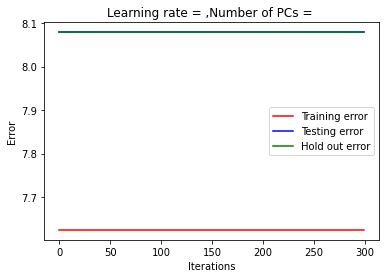

In [25]:
#Plot error/accuracy 
plt.plot(train_error,color = 'red',label = 'Training error')
plt.plot(test_error,color = 'blue',label = 'Testing error')
plt.plot(hold_out_error,color = 'green',label = 'Hold out error')
plt.title("Learning rate = ,Number of PCs = ")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.legend()
plt.show()

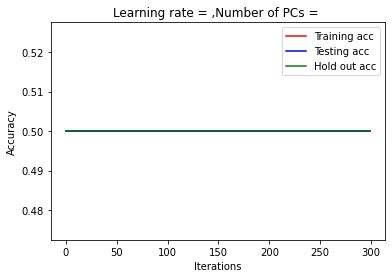

In [26]:
plt.plot(train_acc,color = 'red',label = 'Training acc')
plt.plot(test_acc,color = 'blue',label = 'Testing acc')
plt.plot(hold_out_acc,color = 'green',label = 'Hold out acc')
plt.title("Learning rate = ,Number of PCs = ")
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()